In [50]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from alphamind.api import *
from PyFin.api import *

## 1. 准备因子历史数据
-----------------------

In [61]:
factor_name = 'ROE'
neutralized_styles = industry_styles
start_date = '2010-01-01'
end_date = '2019-02-01'
engine = SqlEngine(os.environ['DB_URI'])
universe_name = 'zz800'
freq = '5b'

In [62]:
universe = Universe(universe_name)
dates = makeSchedule(start_date, end_date, freq, calendar='china.sse')
factors = engine.fetch_factor_range(universe, factor_name, dates=dates)
risk_cov, risk_factors = engine.fetch_risk_model_range(universe, dates=dates)
dx_returns = engine.fetch_dx_return_range(universe, dates=dates, horizon=map_freq(freq))
total_data = pd.merge(factors, risk_factors, on=['trade_date', 'code'])
total_data = pd.merge(total_data, dx_returns, on=['trade_date', 'code'])
total_data.dropna(inplace=True)

## 2. 计算历史IC序列
----------------------

In [63]:
neutralized_factors = neutralize(total_data[neutralized_styles].values.astype(float),
                                 total_data['ROE'].values,
                                 groups=total_data['trade_date'])
total_data['neutralized_factors'] = neutralized_factors

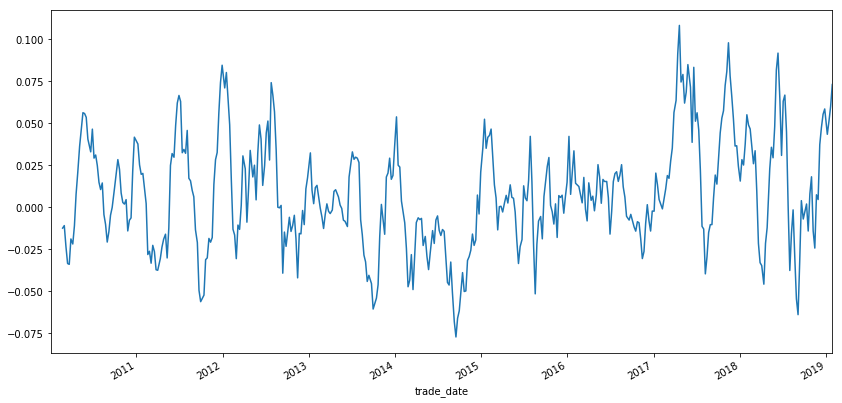

In [70]:
ic_series = total_data.groupby('trade_date').apply(lambda x: np.corrcoef(x['neutralized_factors'], x['dx'])[0, 1])
ic_series.rolling(window=7).mean().plot(figsize=(14, 7))